Retail demand/inventory forecasting using Linear Regression with lag features; evaluated vs. naive Lag-1 baseline.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

Analyse

In [71]:
df = pd.read_csv("../data/inventory.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Price               73100 non-null  float64
 9   Discount            73100 non-null  int64  
 10  Weather Condition   73100 non-null  object 
 11  Holiday/Promotion   73100 non-null  int64  
 12  Competitor Pricing  73100 non-null  float64
 13  Seasonality         73100 non-null  object 
dtypes: float64(2), int64(5), object(7)
memory usage: 7.8+ MB


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S004,P0013,Furniture,East,191,56,65,61.81,0,Sunny,0,63.92,Autumn
2,2022-01-01,S004,P0012,Electronics,North,349,9,165,14.25,5,Rainy,1,18.56,Spring
3,2022-01-01,S004,P0011,Electronics,West,205,46,27,54.84,0,Sunny,1,57.76,Spring
4,2022-01-01,S004,P0010,Groceries,East,447,104,96,33.48,15,Cloudy,0,37.15,Summer


In [57]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

In [58]:
df["Lag1"] = df["Inventory Level"].shift(1)
df["Lag2"] = df["Inventory Level"].shift(2)
df["MA7"] = df["Inventory Level"].rolling(window=7).mean()

df = df.dropna()

In [59]:
features = ["Lag1", "Lag2", "MA7", "Units Sold", "Price"]

x = df[features]
y = df["Inventory Level"]

split_index = int(len(x) * 0.8)

x_train, x_test = x.iloc[:split_index], x.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

assert len(x_test) > 0, "Test set ist leer"

In [60]:
model = LinearRegression()
model.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [61]:
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("=== Linear Regression ===")
print(f"MAE :  {mae:.2f}")
print(f"RMSE:  {rmse:.2f}")

=== Linear Regression ===
MAE :  79.60
RMSE:  97.82


In [62]:
y_pred_baseline = x_test["Lag1"].values

mae_base = mean_absolute_error(y_test, y_pred_baseline)
rmse_base = root_mean_squared_error(y_test, y_pred_baseline)

print("\n=== Baseline (Lag1) ===")
print(f"MAE :  {mae_base:.2f}")
print(f"RMSE:  {rmse_base:.2f}")



=== Baseline (Lag1) ===
MAE :  150.68
RMSE:  183.82


In [63]:
improvement = (rmse_base - rmse) / rmse_base * 100
print(f"Improvement: {improvement:.1f}%")

Improvement: 46.8%


In [64]:
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\n=== Feature Influence ===")
print(coef_df)

if rmse < rmse_base:
    print("\n✔ Model beats baseline")
else:
    print("\n✘ Model does NOT beat baseline")


=== Feature Influence ===
      Feature  Coefficient
2         MA7     0.981849
3  Units Sold     0.606313
1        Lag2    -0.142216
0        Lag1    -0.137586
4       Price     0.050516

✔ Model beats baseline


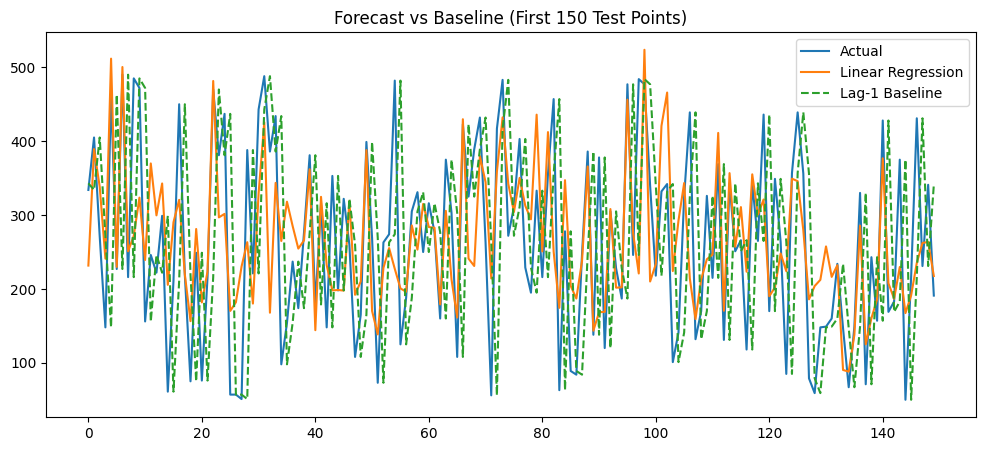

In [65]:
N = 150
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:N], label="Actual")
plt.plot(y_pred[:N], label="Linear Regression")
plt.plot(y_pred_baseline[:N], label="Lag-1 Baseline", linestyle="--")
plt.legend()
plt.title("Forecast vs Baseline (First 150 Test Points)")
plt.show()

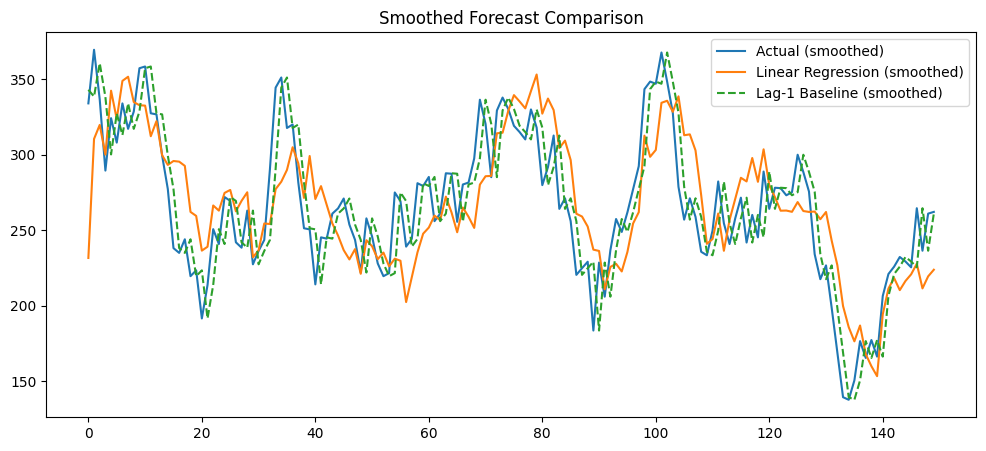

In [66]:
def smooth(x, window=7):
    return pd.Series(x).rolling(window, min_periods=1).mean()

plt.figure(figsize=(12,5))
plt.plot(smooth(y_test.values[:N]), label="Actual (smoothed)")
plt.plot(smooth(y_pred[:N]), label="Linear Regression (smoothed)")
plt.plot(smooth(y_pred_baseline[:N]), label="Lag-1 Baseline (smoothed)", linestyle="--")
plt.legend()
plt.title("Smoothed Forecast Comparison")
plt.show()

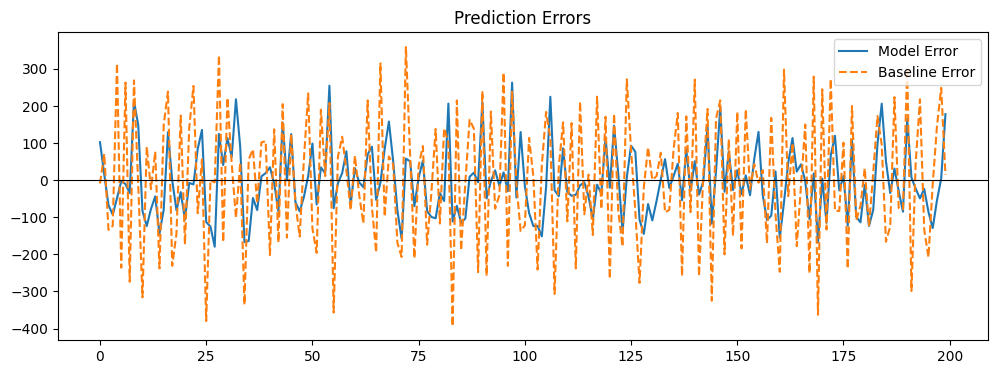

In [67]:
err_model = y_test.values - y_pred
err_base = y_test.values - y_pred_baseline
M = 200
plt.figure(figsize=(12,4))
plt.plot(err_model[:M], label="Model Error")
plt.plot(err_base[:M], label="Baseline Error", linestyle="--")
plt.axhline(0, color="black", linewidth=0.8)
plt.legend()
plt.title("Prediction Errors")
plt.show()